word2vec is a technique for encoding words (or other tokens in a sequence) into high dimensional vectors. These vectors can be used for similarity lookups and arithmetic operations. The word2vec algorithm is implemented by [gensim](https://radimrehurek.com/gensim/).

In [1]:
from gensim.models import Word2Vec

Instead of spending days training our own model on lots of text, we can load a pre-trained model. This one was [trained by Google](https://code.google.com/p/word2vec/) on three million unique words and phrases in news articles. Each word is embedded in a 300-dimensional space. It's a 3.6GB file and can take almost two minutes to load this model from disk.

In [2]:
model = Word2Vec.load_word2vec_format('../../models/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

We can look up the vector for a single word like this:

In [3]:
vector = model['Japan']
print(vector.shape)

(300,)


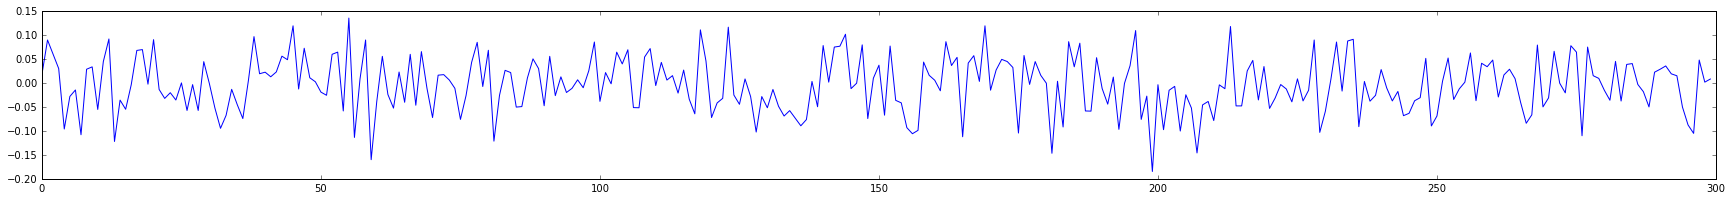

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[30, 3])
plt.plot(vector)
plt.show()

If we sort the dimensions by one vector, we can see the similar words follow it, and the dissimilar one does not.

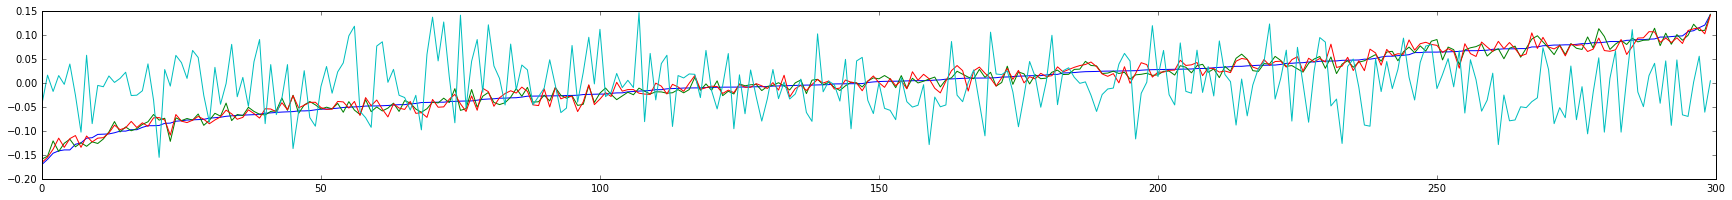

In [68]:
plt.figure(figsize=[30, 3])
plt.plot(sorted(zip(model['Tuesday'], model['Wednesday'], model['Thursday'], model['teapot'])))
plt.show()

Using these vectors we can make metaphors, such as "What is the Berlin of Japan (instead of Germany)?" also written `Berlin + Japan - Germany`:

In [5]:
model.most_similar(positive=['Berlin', 'Japan'], negative=['Germany'])

[(u'Tokyo', 0.7485347390174866),
 (u'Toyko', 0.61406409740448),
 (u'Japanese', 0.582942008972168),
 (u'Seoul', 0.5801318883895874),
 (u'Fukuoka', 0.5745269060134888),
 (u'Nagoya', 0.5597074627876282),
 (u'Aomori', 0.5552584528923035),
 (u'Osaka', 0.5507833361625671),
 (u'Tsuruoka', 0.5430541038513184),
 (u'Ishihara', 0.5422928333282471)]

Or, "What is a queen as a man (instead of a woman)?" Notice that the words are case sensitive.

In [6]:
model.most_similar(positive=['queen', 'man'], negative=['woman'])

[(u'king', 0.6958589553833008),
 (u'kings', 0.5950948596000671),
 (u'queens', 0.5838503241539001),
 (u'monarch', 0.5398427844047546),
 (u'prince', 0.522361695766449),
 (u'princess', 0.5175283551216125),
 (u'princes', 0.49844634532928467),
 (u'royal', 0.49245917797088623),
 (u'NYC_anglophiles_aflutter', 0.4859851002693176),
 (u'Eugene_Ionesco_absurdist_comedy', 0.47842416167259216)]

We can look for the most similar words in the 1000 most common words.

In [71]:
limit = 1000
limited = model.index2word[:limit]
matches = [(model.most_similar(positive=[word], topn=1, restrict_vocab=limit)[0], word) for word in limited]
sorted([(x[1],x[0],y) for x,y in matches], reverse=True)[:10]

[(0.98166823387146, u'Wednesday', u'Thursday'),
 (0.98166823387146, u'Thursday', u'Wednesday'),
 (0.979229211807251, u'Wednesday', u'Tuesday'),
 (0.9720568656921387, u'Tuesday', u'Monday'),
 (0.9703431129455566, u'three', u'four'),
 (0.9703431129455566, u'four', u'three'),
 (0.9675939679145813, u'January', u'February'),
 (0.9675939083099365, u'February', u'January'),
 (0.963593602180481, u'February', u'October'),
 (0.9619012475013733, u'seven', u'eight')]

gensim also provides interfaces for how similar two words are.

In [7]:
model.similarity('computer', 'calculator')

0.33398881807965902

In [8]:
model.similarity('computer', 'rain')

0.060617714683846399

Or which words don't belong.

In [9]:
model.doesnt_match('breakfast dinner lunch cereal'.split())

'cereal'

In [10]:
model.doesnt_match("sweet sour salty wet".split())

'wet'

As you work with word2vec you will notice that opposites are more similar to each other than they are to very different things:

In [15]:
model.similarity('hot', 'cold')

0.46021387160411026

In [16]:
model.similarity('hot', 'laptop')

0.079516639360773994

For a set of words we can plot their similarities to each other, and see that each group of three is similar to each other but not to the others.

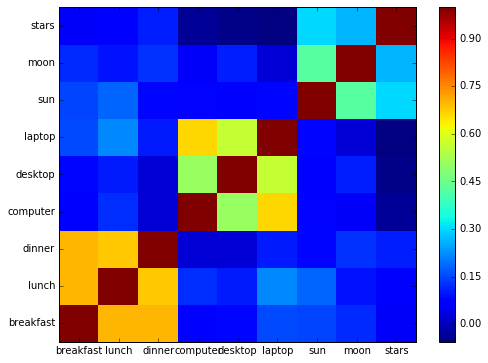

In [12]:
import numpy as np

words = ['breakfast', 'lunch', 'dinner',
        'computer', 'desktop', 'laptop',
        'sun', 'moon', 'stars']
vectors = [model[word] for word in words]
similar = [np.dot(vectors, vector) for vector in vectors]

plt.figure(figsize=(8, 6))
plt.pcolor(np.array(similar))
plt.colorbar()
plt.yticks(0.5 + np.arange(len(words)), words)
plt.xticks(0.5 + np.arange(len(words)), words)
plt.show()

Another idea is to find a path from one word to another. Instead of doing a linear interpolation from one vector to another, we need to do a high-dimensional spherical interpolation. This example uses code from [Transorthogonal Linguistics](https://github.com/thoppe/transorthogonal-linguistics/blob/master/transorthogonal_linguistics/slerp_word_path.py). They do some extra filtering to get better results, and you can test it [here](http://transorthogonal-linguistics.herokuapp.com/TOL/boy/man).

In [13]:
from gensim import matutils
def slerp_points(x0,x1,slerp_n):
    theta = np.arccos(x0.dot(x1))
    st = np.sin(theta)
    T  = np.linspace(0,1,slerp_n)
    L1 = np.sin((1-T)*theta)/st
    L2 = np.sin(T*theta)/st
    SL = np.outer(L1,x0) + np.outer(L2,x1)
    return (SL.T / np.linalg.norm(SL,axis=1)).T
def print_path(start, end, steps=10, limit=100000, topn=10):
    x0 = model[start]
    x1 = model[end]
    all_words = [start, end]
    between = slerp_points(x0, x1, steps)
    limited = model.syn0norm if limit is None else model.syn0norm[:limit]
    for x in between:
        sims = np.dot(limited, matutils.unitvec(x))
        best = matutils.argsort(sims, topn=topn, reverse=True)
        print ' '.join([model.index2word[i] for i in best if not model.index2word[i] in all_words])

In [14]:
print_path('sweet', 'sour')

sweetness sweetest yummy buttery delicious fruity tasty lovely tangy
sweetness sweetest yummy buttery fruity delicious sweeter tart tasty
sweetness sweetest sweeter fruity tart yummy buttery delicious
sweetness sweeter tart fruity savory sweetest yummy spicy
sweeter tart sweetness savory fruity spicy salty sweetest
sweeter tart savory salty soured sweetness bitter souring
soured souring sweeter tart bitter frosty savory Sour
soured souring bitter frosty Sour tart sweeter rancid
soured souring bitter frosty rancid Sour bad tart
soured souring frosty rancid bitter awry Sour bad horribly_wrong


Finally, if you have a set of words you can sort them so that the path from one word to the next is always similar. This can be done with a traveling salesperson solver, like [this one in Python](https://github.com/dmishin/tsp-solver) or [this one from Google](https://developers.google.com/optimization/routing/tsp?hl=en). Here's a [list of moods](https://gist.github.com/kylemcdonald/e425243c41b2c41de5ba) sorted by their word2vec vector distance: `...fearless courageous brave daring bold framed blank fake phony inflated manipulated...`